In [1]:
from qiskit.algorithms import VQE, NumPyMinimumEigensolver, NumPyEigensolver #Algorithms

#Qiskit odds and ends
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import COBYLA, SPSA, SLSQP, L_BFGS_B
from qiskit.opflow import Z2Symmetries, X, Y, Z, I, PauliSumOp, Gradient
from qiskit import IBMQ, BasicAer, Aer
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit.utils.mitigation import CompleteMeasFitter #Measurement error mitigatioin
from qiskit.tools.visualization import circuit_drawer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from qiskit.test.mock import FakeManila, FakeNairobi

#qiskit_nature
from qiskit_nature.circuit.library import UCCSD, PUCCD, SUCCD, HartreeFock, CHC, VSCF
from qiskit_nature.drivers.second_quantization import PySCFDriver
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.drivers import Molecule
from qiskit_nature.drivers.second_quantization import ElectronicStructureMoleculeDriver, ElectronicStructureDriverType
from qiskit_nature.transformers.second_quantization.electronic import ActiveSpaceTransformer , FreezeCoreTransformer
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
from qiskit_nature.algorithms import AdaptVQE,VQEUCCFactory, GroundStateEigensolver, QEOM, NumPyEigensolverFactory, ExcitedStatesEigensolver

#Noise
from qiskit.providers.aer.noise import NoiseModel
from qiskit.providers.aer.noise import QuantumError, ReadoutError
from qiskit.providers.aer.noise import pauli_error
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error

#Python odds and ends
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
import pylab
import numpy as np
import os
import pyscf
from IPython.display import display, clear_output

from datetime import datetime
%matplotlib inline
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
#set Backends
#simulators
backend_stv = Aer.get_backend('aer_simulator_statevector')
#Noisy simulator
backend_aer = Aer.get_backend('aer_simulator')
#Real Devices
backend_manil = provider.get_backend('ibmq_manila')
backend_qsm_ibm=provider.get_backend('ibmq_qasm_simulator')

sh=1024 #shots

#solvers
npme = NumPyMinimumEigensolver()
npe=NumPyEigensolver()

In [2]:
def exact_solver(problem, converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(converter, solver)
    result = calc.solve(problem)
    return result

In [3]:
#Make qubit_operator

def get_qubit_op(dist,mapper):
    
    
    #Define Molecule
    molecule = Molecule(
        # coordinates in Angstrom
        geometry=[
            ["Li", [0.0, 0.0, 0.0]],
            ["H", [dist, 0.0, 0.0]]
        ],
        multiplicity=1,  # = 2*spin + 1
        charge=0,
    )
    
    #Set driver
    driver = ElectronicStructureMoleculeDriver(
        molecule=molecule,
        basis="sto3g",
        driver_type=ElectronicStructureDriverType.PYSCF,
    )

    #Get properties
    properties = driver.run()
    
    #particle_number = problem.grouped_property_transformed.get_property("ParticleNumber")
    num_a_electrons = properties.get_property("ParticleNumber").num_alpha
    num_b_electrons = properties.get_property("ParticleNumber").num_beta
    num_particles=properties.get_property("ParticleNumber").num_particles

    num_spin_orbitals = properties.get_property("ParticleNumber").num_spin_orbitals
    num_spin_orbitals= num_spin_orbitals.item()
    type(np.float64(0).item())

    rep_energy = properties.get_property("ElectronicEnergy").nuclear_repulsion_energy
    en_shift=0
    #en_shift=properties.get_property("ElectronicEnergy").energy_shift
    shift=rep_energy+en_shift
    
    # Check the occupation of the spin orbitals
    PN_property = properties.get_property("ParticleNumber")

    # Define the active space
    # (selected automatically around the HOMO and LUMO, ordered by energy)
    transformer = ActiveSpaceTransformer(
        num_electrons=4, #Electrons in active space
        num_molecular_orbitals=4, #Orbitals in active space
    )
    
    #Define the problem

    problem = ElectronicStructureProblem(driver
                                         , [
                                          #   transformer 
                                                   FreezeCoreTransformer(freeze_core=True
                                                                         , remove_orbitals=[3,4]
                                                                         )
                                           ]
                                        )
    
    second_q_ops = problem.second_q_ops() # Get 2nd Quant OP. This calls driver.run() internally
    
    num_spin_orbitals = problem.num_spin_orbitals
    num_particles = problem.num_particles
    
    hamiltonian = second_q_ops[0] #Set Hamiltonian

    #Get Pauli OP
    converter = QubitConverter(mapper)
    qubit_op = converter.convert(hamiltonian)
    
    #Symmetries
    sym=Z2Symmetries.find_Z2_symmetries(qubit_op)
    converter = QubitConverter(mapper
                               #,two_qubit_reduction=True
                               ,z2symmetry_reduction=problem.symmetry_sector_locator(sym,converter)
                              )
    
    #Final OP
    qubit_op = converter.convert(hamiltonian)
    
    
    return qubit_op, num_particles, num_spin_orbitals, converter, problem


def callback(eval_count, parameters, mean, std):  
    # Overwrites the same line when printing
    display("Evaluation: {}, Energy: {}, Std: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    

<h1>Manila Noise Model</h1>

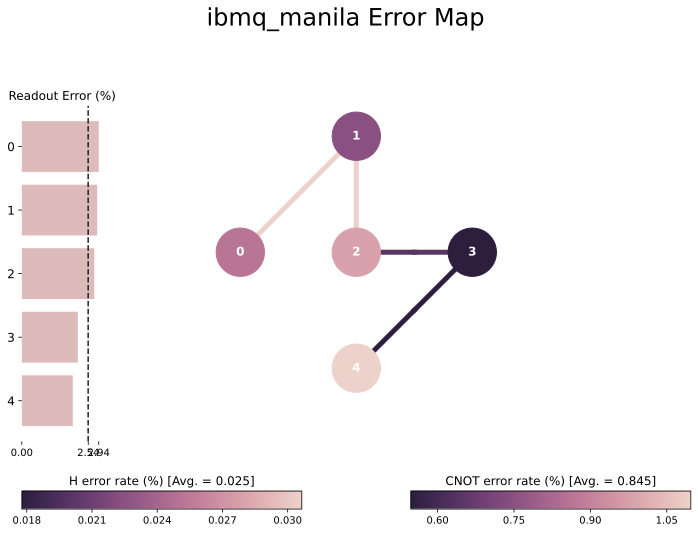

In [28]:
from qiskit.visualization import plot_error_map
plot_error_map(backend_manil)

In [4]:
device_backend=FakeManila()
device = QasmSimulator.from_backend(device_backend)
noise_model_man = None
coupling_map = device.configuration().coupling_map
noise_model_man = NoiseModel.from_backend(device)
basis_gates = noise_model_man.basis_gates

/opt/homebrew/Caskroom/miniforge/base/envs/qiskit-env/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1298: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


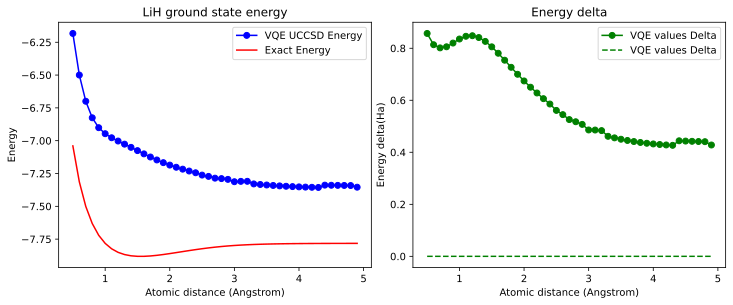

In [6]:
distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_model_man,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #clear_output(wait=True)

fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, np.subtract(vqe_energies,exact_energies), '-go',label="VQE values Delta")
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()
    

<h1>Let's make some Noise models</h1>

<h3>Bit Flip</h3>

In [7]:
num_qubits=qubit_op.num_qubits
basis=['id','x','sx']
error=[]
error_avg=[]
meas_error=[]
us=1e6
ns=1e9
for k in range(num_qubits):
    meas_error=backend_manil.properties().readout_error(k)
for i,bas in enumerate (basis):
    for k in range(num_qubits):
        error.append(backend_manil.properties().gate_error(bas,k))
    error_avg.append(np.mean(error))

In [8]:
#Bit flip
# Example error probabilities
p_reset = 0.03
p_meas = np.mean(meas_error)
p_gate1 = np.mean(error_avg)

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate1, ["id", "sx", "x"])
noise_bit_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bit_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'x', 'sx', 'reset', 'cx']
  All-qubits errors: ['reset', 'measure', 'id', 'sx', 'x', 'cx']


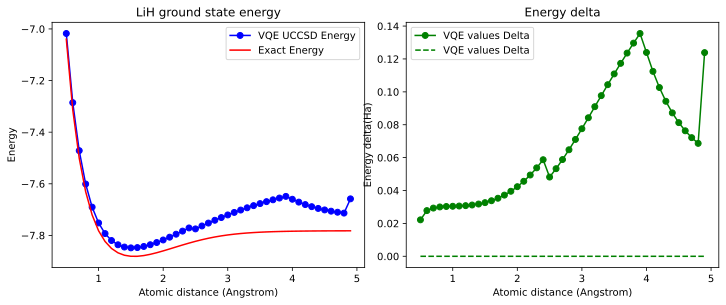

In [55]:
#Make qubit_operator

distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_bit_flip,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #clear_output(wait=True)

fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, np.subtract(vqe_energies,exact_energies), '-go',label="VQE values Delta")
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()
    

<h3>Phase flip</h3>

In [9]:

# QuantumError objects
error_reset = pauli_error([('Z', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
error_gate2 = error_gate1.tensor(error_gate1)

# Add errors to noise model
noise_ph_flip = NoiseModel()
noise_ph_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_ph_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_ph_flip.add_all_qubit_quantum_error(error_gate1, ["id", "sx", "x"])
noise_ph_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_ph_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'x', 'sx', 'reset', 'cx']
  All-qubits errors: ['reset', 'measure', 'id', 'sx', 'x', 'cx']


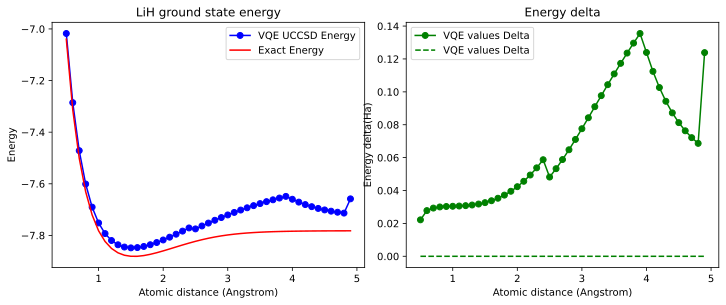

In [57]:
#Make qubit_operator

distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_bit_flip,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #clear_output(wait=True)

fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, np.subtract(vqe_energies,exact_energies), '-go',label="VQE values Delta")
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()
    

<h3>Bit-Phaseflip</h3>

In [10]:

# QuantumError objects
ph_error_reset = pauli_error([('Z', p_reset), ('I', 1 - p_reset)])
ph_error_meas = pauli_error([('Z',p_meas), ('I', 1 - p_meas)])
ph_error_gate1 = pauli_error([('Z',p_gate1), ('I', 1 - p_gate1)])
ph_error_gate2 = ph_error_gate1.tensor(ph_error_gate1)
bit_error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
bit_error_meas = pauli_error([('X',p_meas), ('I', 1 - p_meas)])
bit_error_gate1 = pauli_error([('X',p_gate1), ('I', 1 - p_gate1)])
bit_error_gate2 = bit_error_gate1.tensor(bit_error_gate1)
error_reset=bit_error_reset.compose(ph_error_reset)
error_meas=bit_error_meas.compose(ph_error_meas)
error_gate1=bit_error_gate1.compose(ph_error_gate1)
error_gate2=bit_error_gate2.compose(ph_error_gate2)

# Add errors to noise model
noise_bitph_flip = NoiseModel()
noise_bitph_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bitph_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bitph_flip.add_all_qubit_quantum_error(error_gate1, ["id", "sx", "x"])
noise_bitph_flip.add_all_qubit_quantum_error(error_gate2, ["cx"])

print(noise_bitph_flip)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'x', 'sx', 'reset', 'cx']
  All-qubits errors: ['reset', 'measure', 'id', 'sx', 'x', 'cx']


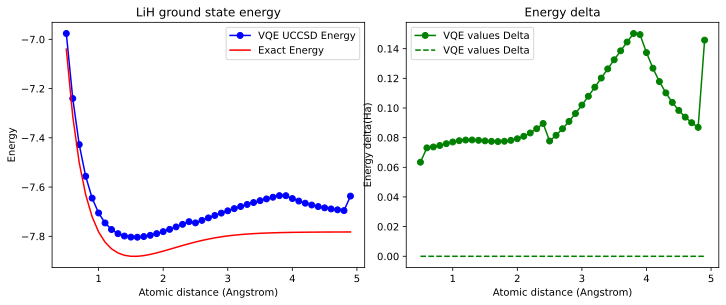

In [59]:
#Make qubit_operator

distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_bitph_flip,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #clear_output(wait=True)

fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, np.subtract(vqe_energies,exact_energies), '-go',label="VQE values Delta")
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()
    

<h3>Thermal noise</h3>

In [11]:
num_qubits=qubit_op.num_qubits
basis=['id','x','sx']
lengths_avg=[]
lengths=[]
T1s=[]
T2s=[]
time_measure=[]
us=1e6
ns=1e9
for k in range(num_qubits):
    T1s.append(backend_manil.properties().t1(k)*ns)
    T2s.append(backend_manil.properties().t2(k)*ns)
    time_measure.append(backend_manil.properties().readout_length(k)*ns)
for i,bas in enumerate (basis):
    for k in range(num_qubits):
        lengths_avg.append(backend_manil.properties().gate_length(bas,k))
    lengths.append(np.mean(lengths_avg)*ns)



In [12]:

# T1 and T2 values for qubits
#T1s = np.random.normal(165.6e3, 76.54e3, num_qubits) # Sampled from normal distribution mean 50 microsec
#T2s = np.random.normal(60.06e3, 27.8e3, num_qubits)  # Sampled from normal distribution mean 70 microsec

# Truncate random T2s <= T1s
#T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(num_qubits)])

# Instruction times (in nanoseconds)
time_x = lengths[1]   
time_sx = lengths[2] 
time_id = lengths[0] 
time_cx = 368
time_reset =np.mean(time_measure)
time_measure = np.mean(time_measure)

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_x  = [thermal_relaxation_error(t1, t2, time_x)
              for t1, t2 in zip(T1s, T2s)]
errors_sx  = [thermal_relaxation_error(t1, t2, time_sx)
              for t1, t2 in zip(T1s, T2s)]
errors_id  = [thermal_relaxation_error(t1, t2, time_id)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()
for j in range(num_qubits):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_x[j], "x", [j])
    noise_thermal.add_quantum_error(errors_sx[j], "sx", [j])
    noise_thermal.add_quantum_error(errors_id[j], "id", [j])
    for k in range(num_qubits):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'rz', 'sx', 'x']
  Instructions with noise: ['measure', 'id', 'x', 'sx', 'reset', 'cx']
  Qubits with noise: [0, 1, 2, 3]
  Specific qubit errors: [('reset', (0,)), ('reset', (1,)), ('reset', (2,)), ('reset', (3,)), ('measure', (0,)), ('measure', (1,)), ('measure', (2,)), ('measure', (3,)), ('x', (0,)), ('x', (1,)), ('x', (2,)), ('x', (3,)), ('sx', (0,)), ('sx', (1,)), ('sx', (2,)), ('sx', (3,)), ('id', (0,)), ('id', (1,)), ('id', (2,)), ('id', (3,)), ('cx', (0, 0)), ('cx', (0, 1)), ('cx', (0, 2)), ('cx', (0, 3)), ('cx', (1, 0)), ('cx', (1, 1)), ('cx', (1, 2)), ('cx', (1, 3)), ('cx', (2, 0)), ('cx', (2, 1)), ('cx', (2, 2)), ('cx', (2, 3)), ('cx', (3, 0)), ('cx', (3, 1)), ('cx', (3, 2)), ('cx', (3, 3))]


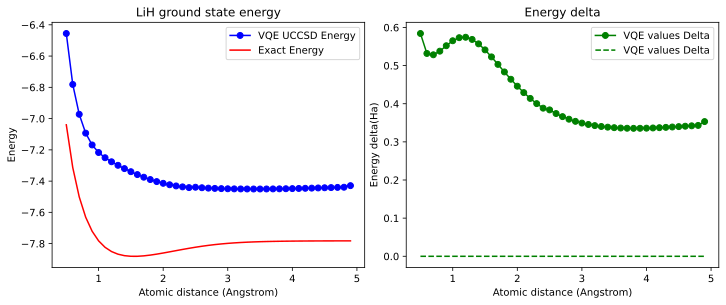

In [62]:
#Make qubit_operator

distances = np.arange(0.5, 5, 0.1)
exact_energies = []
vqe_energies = []
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv
qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                          coupling_map=coupling_map,noise_model=noise_thermal,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

dists=[]

for dist in distances:
    #Qubit_Op
    qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
    #Initial State
    init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
    #ansatz
    ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
    #classic solver
    result_exact = exact_solver(problem, converter = converter)
    exact_energies.append(result_exact.total_energies)
    #VQE

    counts = []
    values = []
    params = []
    deviation = []
    dists.append(dist)

    # Set initial parameters of the ansatz
    initial_point = [0.01] * ansatz.num_parameters

    algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

    vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
    vqe_energies.append(problem.interpret(vqe_calc).total_energies)
    
    #clear_output(wait=True)
    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

ax[0].plot(dists, vqe_energies, '-bo',label="VQE UCCSD Energy")
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()

ax[1].plot(dists, np.subtract(vqe_energies,exact_energies), '-go',label="VQE values Delta")
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()

ValueError: operands could not be broadcast together with shapes (45,1) (46,1) 

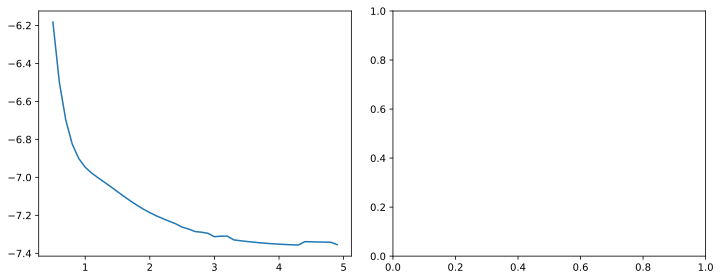

In [50]:
#Make qubit_operator

distances = np.arange(0.5, 5, 0.1)
exact_energies = []
models={'manila':noise_model_man,'bit-flip':noise_bit_flip,'phase-flip':noise_ph_flip,'Bit-phase-flip':noise_bitph_flip,'thermal':noise_thermal}
vqe_energies = [[] for i in enumerate(models)]
optimizer = COBYLA(maxiter=10)
mapper=ParityMapper()


seed = 62
algorithm_globals.random_seed = seed
#qi=backend_stv


for i,(k,v) in enumerate(models.items()):
    qi= QuantumInstance(backend_aer, seed_simulator=seed, seed_transpiler=seed, #Noisy Quantum Instance
                            coupling_map=coupling_map,noise_model=v,
                          measurement_error_mitigation_cls=CompleteMeasFitter)

    dists=[]

    for dist in distances:
        #Qubit_Op
        qubit_op, num_particles, num_spin_orbitals, converter, problem = get_qubit_op(dist,mapper)
        #Initial State
        init_state = HartreeFock(num_spin_orbitals, num_particles, converter)
        #ansatz
        ansatz = UCCSD(converter,num_particles,num_spin_orbitals,initial_state = init_state)
        #classic solver
        if len(exact_energies)<len(distances):
            result_exact = exact_solver(problem, converter = converter)
            exact_energies.append(result_exact.total_energies)
        #VQE

        counts = []
        values = []
        params = []
        deviation = []
        dists.append(dist)

        # Set initial parameters of the ansatz
        initial_point = [0.01] * ansatz.num_parameters

        algorithm = VQE(ansatz
                    ,optimizer=optimizer
                    ,quantum_instance=qi
                    ,callback=callback
                    ,initial_point=initial_point
                   )

        vqe_calc=algorithm.compute_minimum_eigenvalue(qubit_op)
        vqe_energies[i].append(problem.interpret(vqe_calc).total_energies)
    
        #clear_output(wait=True)
    
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

for i,(k,v) in enumerate(models.items()):
    ax[0].plot(dists, vqe_energies[i],label="VQE Energy"+' for '+k)

    ax[1].plot(dists, np.subtract(vqe_energies[i],exact_energies),label="VQE values Delta"+' for '+noise_moidel)
    

ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")                  
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()

In [52]:
exact_energies=np.delete(exact_energies,46,0)
exact_energies

IndexError: index 46 is out of bounds for axis 0 with size 46

TypeError: unsupported operand type(s) for -: 'complex' and 'slice'

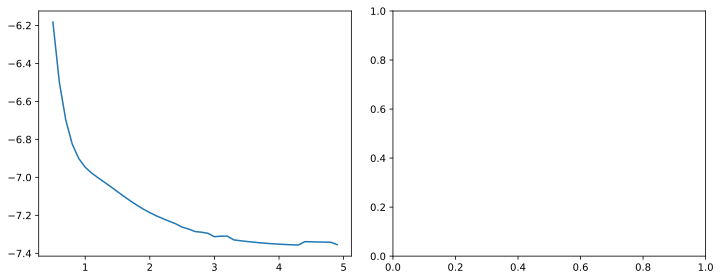

In [33]:
fig, ax=plt.subplots(1,2,figsize=(10,4))
fig.tight_layout()

for i,(k,v) in enumerate(models.items()):
    ax[0].plot(dists, vqe_energies[i],label="VQE Energy"+' for '+k)

    ax[1].plot(dists, np.subtract(vqe_energies[i],exact_energies),label="VQE values Delta"+' for '+k)
    
ax[0].plot(dists, exact_energies,'r' ,label="Exact Energy")                  
ax[0].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy',title='LiH ground state energy')
ax[0].legend()
ax[1].plot(dists, [0]*len(distances), '--g',label="VQE values Delta")
ax[1].set(xlabel='Atomic distance (Angstrom)',ylabel='Energy delta(Ha)',title='Energy delta')
ax[1].legend()


plt.show()

In [23]:
len(exact_energies)

179